In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q efficientnet

In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
import tensorflow.keras as keras
from keras.utils.np_utils import to_categorical

# Preprocessing

In [4]:
raw_dir = '/kaggle/input/flower-image-dataset/flowers'
path = []
label = []
for i in os.listdir(raw_dir):
    path.append(os.path.join(raw_dir,i))
    label.append(i.split('_')[0])

raw_input = pd.DataFrame({'path':path,
                          'label':label})
raw_input.head()

,path,label
0,/kaggle/input/flower-image-dataset/flowers/gar...,gardenias
1,/kaggle/input/flower-image-dataset/flowers/peo...,peonies
2,/kaggle/input/flower-image-dataset/flowers/peo...,peonies
3,/kaggle/input/flower-image-dataset/flowers/orc...,orchids
4,/kaggle/input/flower-image-dataset/flowers/gar...,gardenias


In [5]:
# Check the number of images from each category
raw_input['label'].value_counts()

daisies          83
lilies           81
gardenias        77
peonies          75
garden           74
hibiscus         74
bougainvillea    74
tulip            71
orchids          64
hydrangeas       60
Name: label, dtype: int64

In [6]:
# Convert label to Int category
LE = LabelEncoder()
raw_input['category'] = LE.fit_transform(raw_input['label'])

In [7]:
raw_input.head()

,path,label,category
0,/kaggle/input/flower-image-dataset/flowers/gar...,gardenias,3
1,/kaggle/input/flower-image-dataset/flowers/peo...,peonies,8
2,/kaggle/input/flower-image-dataset/flowers/peo...,peonies,8
3,/kaggle/input/flower-image-dataset/flowers/orc...,orchids,7
4,/kaggle/input/flower-image-dataset/flowers/gar...,gardenias,3


# Prepare Images

In [8]:
# Prepare images
all_images = []
img_size = 800
for i in tqdm(path):
    image = cv2.imread(i)
    image = cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
    all_images.append(image)

  0%|          | 0/733 [00:00<?, ?it/s]

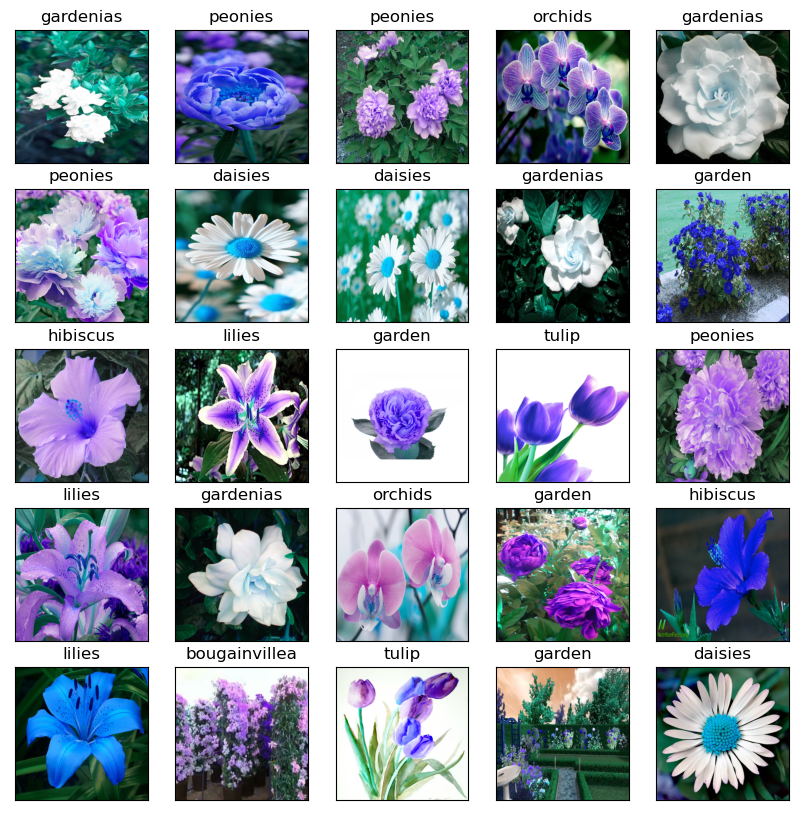

In [9]:
# Plot first 25 images with label
plt.figure(figsize=(10,10))
for i in range(25) :
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(label[i]) 
    plt.grid(False)
    plt.imshow(all_images[i])

In [10]:
# Train test split
X = raw_input['path'].values
y = to_categorical(raw_input['category'], num_classes = 10)
X_2, X_test, y_2, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle = True, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_2, y_2, test_size=0.2, random_state=42,shuffle = True, stratify = y_2)

In [11]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Prepare Data

In [12]:
# Prepare Data
def decode_image(filepath, label=None, image_size=(img_size, img_size)):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [13]:
batch_size = 16

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .map(decode_image)
    .cache()
    .map(data_augment)
    .batch(batch_size)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .map(decode_image)
    .batch(batch_size)
    .cache()
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test, y_test))
    .map(decode_image)
    .batch(batch_size)
    .cache()
)

In [14]:
# Build Model

# model = tf.keras.Sequential([
#         efn.EfficientNetB7(
#                             input_shape=(img_size, img_size, 3),
#                             weights='noisy-student',
#                             include_top=False
#         ),
#         L.GlobalMaxPooling2D(),
#         L.Dense(10, activation='softmax')
#                             ])

# Model 1 - EfficientnetB7

In [15]:
pretrained_model = efn.EfficientNetB7(
    input_shape=(img_size, img_size, 3),
    weights='noisy-student',
    include_top=False,
    pooling='avg')
pretrained_model.trainable = False

258068648/258068648 [==============================] - 12s 0us/step


In [16]:
inputs_efn = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
output = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs_efn, outputs=output)

In [17]:
model.compile(
                optimizer = 'Adam',
                loss = 'categorical_crossentropy',
                metrics=['categorical_accuracy']
              )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 400, 400, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 400, 400, 64  256         ['stem_conv[0][0]']              
                                )                                                             

In [18]:
history = model.fit(train_dataset,validation_data=valid_dataset, epochs=30)

Epoch 1/30


2023-03-19 18:10:22.905668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 [==============================] - 98s 2s/step - loss: 1.4311 - categorical_accuracy: 0.5863 - val_loss: 0.6703 - val_categorical_accuracy: 0.8409
Epoch 2/30
33/33 [==============================] - 58s 2s/step - loss: 0.5108 - categorical_accuracy: 0.8558 - val_loss: 0.3575 - val_categorical_accuracy: 0.8864
Epoch 3/30
33/33 [==============================] - 58s 2s/step - loss: 0.3844 - categorical_accuracy: 0.8918 - val_loss: 0.2436 - val_categorical_accuracy: 0.9242
Epoch 4/30
33/33 [==============================] - 58s 2s/step - loss: 0.3107 - categorical_accuracy: 0.9089 - val_loss: 0.2021 - val_categorical_accuracy: 0.9545
Epoch 5/30
33/33 [==============================] - 58s 2s/step - loss: 0.2554 - categorical_accuracy: 0.9165 - val_loss: 0.1882 - val_categorical_accuracy: 0.9394
Epoch 6/30
33/33 [==============================] - 58s 2s/step - loss: 0.2470 - categorical_accuracy: 0.9222 - val_loss: 0.1754 - val_categorical_accuracy: 0.9545
Epoch 7/30
33/33 [=========

In [19]:
model.evaluate(test_dataset)

5/5 [==============================] - 8s 1s/step - loss: 0.1542 - categorical_accuracy: 0.9459


[0.15424123406410217, 0.9459459185600281]

In [20]:
predict1 = model.predict(test_dataset, verbose=1)

5/5 [==============================] - 10s 1s/step


# Model 2 - InceptionV3

In [22]:
pretrained_model2 = InceptionV3(
    input_shape=(img_size, img_size, 3),
    weights='imagenet',
    include_top=False,
    pooling='avg')
pretrained_model2.trainable = False

87910968/87910968 [==============================] - 4s 0us/step


In [23]:
inputs_inc = pretrained_model2.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model2.output)
output = tf.keras.layers.Dense(10, activation='softmax')(x)
model2 = tf.keras.Model(inputs=inputs_inc, outputs=output)

In [24]:
model2.compile(
                optimizer = 'Adam',
                loss = 'categorical_crossentropy',
                metrics=['categorical_accuracy']
              )
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 399, 399, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 399, 399, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [25]:
history2 = model2.fit(train_dataset,validation_data=valid_dataset, epochs=30)

Epoch 1/30
33/33 [==============================] - 19s 399ms/step - loss: 1.7860 - categorical_accuracy: 0.4023 - val_loss: 1.2691 - val_categorical_accuracy: 0.6212
Epoch 2/30
33/33 [==============================] - 9s 287ms/step - loss: 0.9844 - categorical_accuracy: 0.7306 - val_loss: 0.8654 - val_categorical_accuracy: 0.7803
Epoch 3/30
33/33 [==============================] - 9s 286ms/step - loss: 0.6663 - categorical_accuracy: 0.8330 - val_loss: 0.6876 - val_categorical_accuracy: 0.8106
Epoch 4/30
33/33 [==============================] - 9s 286ms/step - loss: 0.4992 - categorical_accuracy: 0.8824 - val_loss: 0.5532 - val_categorical_accuracy: 0.8409
Epoch 5/30
33/33 [==============================] - 9s 288ms/step - loss: 0.4055 - categorical_accuracy: 0.8975 - val_loss: 0.4952 - val_categorical_accuracy: 0.8485
Epoch 6/30
33/33 [==============================] - 9s 286ms/step - loss: 0.3258 - categorical_accuracy: 0.9203 - val_loss: 0.4544 - val_categorical_accuracy: 0.8561
Epo

In [26]:
model2.evaluate(test_dataset)

5/5 [==============================] - 2s 498ms/step - loss: 0.1721 - categorical_accuracy: 0.9324


[0.1720803678035736, 0.9324324131011963]

In [27]:
predict2 = model2.predict(test_dataset, verbose=1)

5/5 [==============================] - 2s 219ms/step


# Combine 2 Models

In [54]:
# Avg Predictions
final_pred = predict1 * 0.5+ predict2 * 0.6

final_acc_score = accuracy_score(y_test.argmax(axis=1),final_pred.argmax(axis=1))

In [55]:
final_acc_score

0.9594594594594594